In [1]:
import cv2
import os
import ast
from modules_segmentation import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

##### Step 1: Get training set of uncropped images (and manual labels for evaluation only) as specified by split

see 01_copy_uncropped_training_set.py: just copying files/labels in pairs

##### Step 2: Rotate images to have the header in the same place for all of the images

see 02_rotate_images.py: automated detection with manual control afterwards

would be not necessary if all images are orientated the same way in the beginning or if backgrounds with only one color are used

##### Step 3: Generate a mask to cancel out the unwanted foreground elements of the images

see 03_generate mask.py: Overlaying several images with different angles to get a better coverage, removing noise, binarize the image, thicken the contours found

would not be necessary if backgrounds with only one color are used

Some tested masks (final one was used)

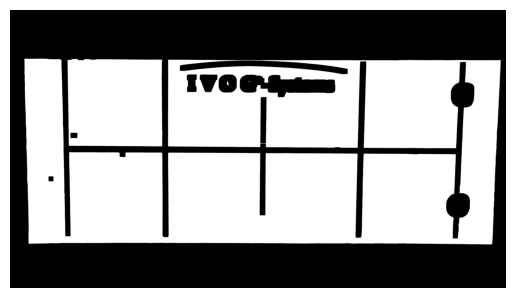

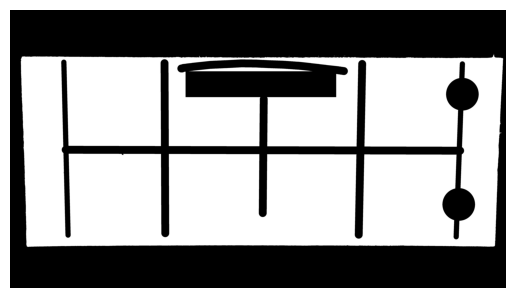

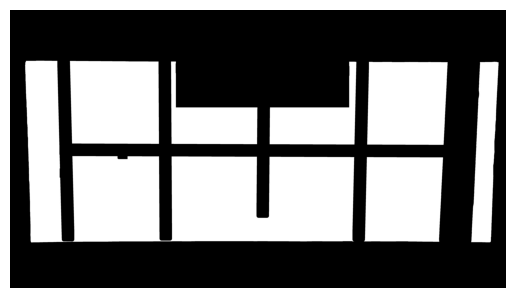

In [2]:
path = "/user/christoph.wald/u15287/insect_pest_detection/2_4_image_processing/masks"
filenames = os.listdir("/user/christoph.wald/u15287/insect_pest_detection/2_4_image_processing/masks")
show(cv2.imread(os.path.join(path,filenames[0])))
show(cv2.imread(os.path.join(path,filenames[1])))
show(cv2.imread(os.path.join(path,filenames[4])))


#### Step 4: Process the images

04_process_images.py: Use the mask to filter out unwanted foreground elements

Returns cropped images, cropped images with masked out elements and manual labels adapted to the cropping (for evaluation only)

would not be necessary if backgrounds with only one color are used

In [3]:
#load mask
processed_mask = cv2.imread(
    "/user/christoph.wald/u15287/insect_pest_detection/2_4_image_processing/masks/04_generated_mask_fat.jpg", 
    cv2.IMREAD_GRAYSCALE
)

#load original image of mask
original_mask = cv2.imread(
    "/user/christoph.wald/u15287/big-scratch/00_uncropped_dataset/YSTohneInsekten/IMG_5885.JPG")

#load corners of YST in the mask
gridcorners = np.load("/user/christoph.wald/u15287/insect_pest_detection/2_4_image_processing/masks/gridcorners.npy")

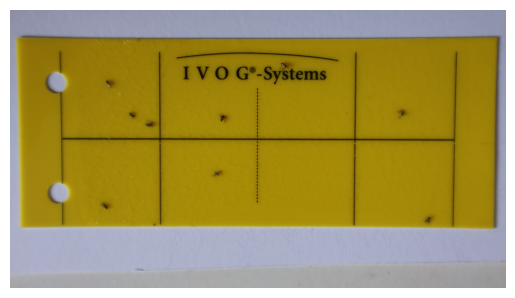

In [4]:
#load image
image_folder = "/user/christoph.wald/u15287/big-scratch/02_splitted_data/train_labeled/images_uncropped"
image_files = os.listdir(image_folder)
image_file = image_files[11]
image = cv2.imread(os.path.join(image_folder, image_file))
#show
show(image)

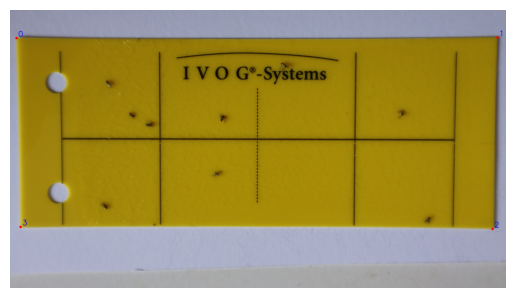

In [5]:
#find YST contour and its corners
imageYST = find_contour(image)
imagecorners = find_corners(image, imageYST)
#show
show(draw_corners(image, imagecorners))


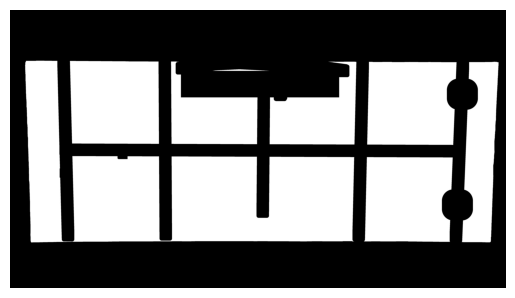

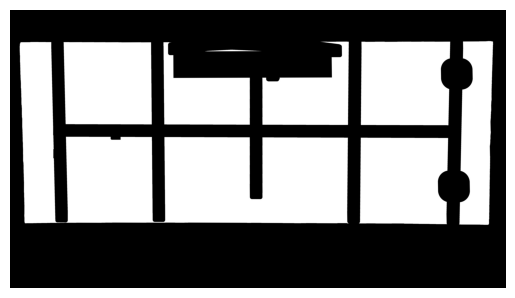

In [6]:

#find transformation
H, _ = cv2.findHomography(gridcorners, imagecorners, cv2.RANSAC)
#transform mask
mask = cv2.warpPerspective(processed_mask, H, (image.shape[1], image.shape[0]))
#only for later demonstration
original_mask_transformed = cv2.warpPerspective(create_binary_mask(original_mask), H, (image.shape[1], image.shape[0]))
#show
show(processed_mask)
show(mask)

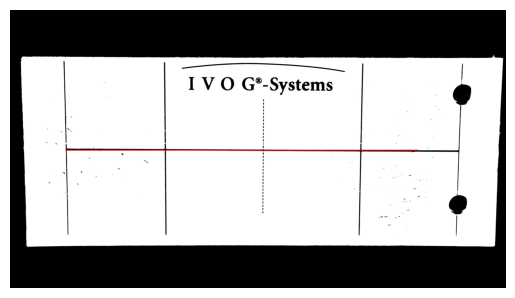

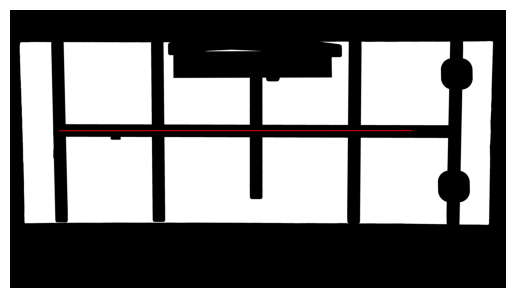

In [7]:
 #get midline from original mask image and transform as above to fit on the transformed mask
x1, y1, x2, y2 = get_h_mid(create_binary_mask(original_mask))

h_line_pts = np.array([
    [x1, y1],
    [x2, y2]
], dtype=np.float32).reshape(-1,1,2)
h_line_pts_warped = cv2.perspectiveTransform(h_line_pts, H)
x1w, y1w, x2w, y2w = h_line_pts_warped.reshape(-1).astype(np.int32)
mask_h = (x1w, y1w, x2w, y2w)
#show
show(check_h_line(create_binary_mask(original_mask), (x1,y1,x2,y2)))
show(check_h_line(mask, mask_h))

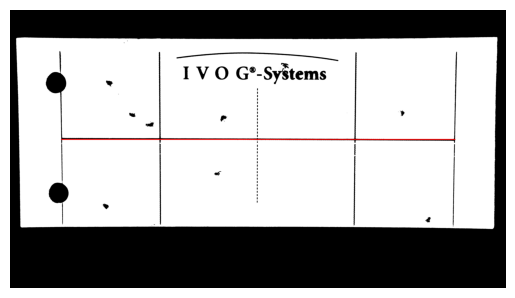

Distance: 105.0


In [8]:
#get midline for image and distance of the midlines
image_h = get_h_mid(create_binary_mask(image))
dy = get_midpoint(image_h)- get_midpoint(mask_h)
#show
show(check_h_line(create_binary_mask(image), image_h))
print(f"Distance: {dy}")

In [9]:
if abs(dy) > 500:
    print(f"Skipped vertical alignment, wrong horizontal line with offset {dy}")
else:
    H, W = mask.shape[:2]
    M = np.float32([[1, 0, 0], [0, 1, dy]])  # translation matrix
    shifted_mask= cv2.warpAffine(mask, M, (W, H), borderValue=255)  # white background
#not easily visible but see below for effect

Single image mask aligned


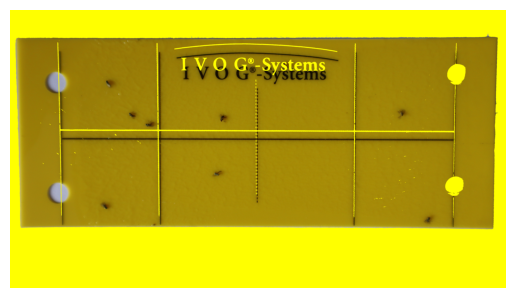

Generated mask aligned


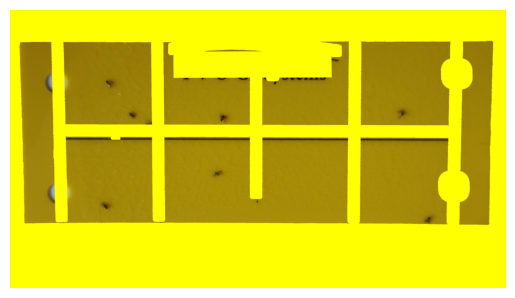

Generated mask with extra vertical shift


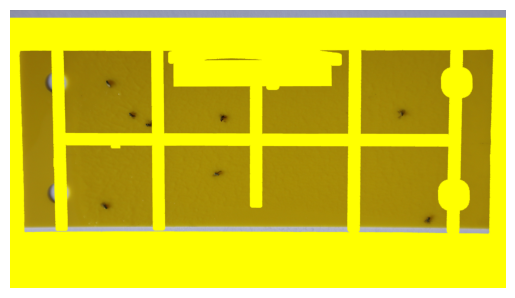

In [10]:
def create_masked_image(mask_to_use, image):
    yellow_mask = mask_to_use == 0
    image_wo_grid = image.copy()
    image_wo_grid[yellow_mask] =  [0, 255, 255]
    return image_wo_grid

masked_with_empty_YST = create_masked_image(original_mask_transformed, image)
masked_with_transformed_mask = create_masked_image(mask, image)
image_wo_grid = create_masked_image(shifted_mask, image)
#show
print("Single image mask aligned")
show(masked_with_empty_YST)
print("Generated mask aligned")
show(masked_with_transformed_mask)
print("Generated mask with extra vertical shift")
show(image_wo_grid)

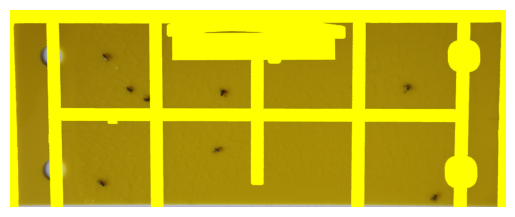

In [11]:
#crop the image
x, y, w, h = cv2.boundingRect(imageYST)
cropped_image_wo_grid = image_wo_grid[y:y+h, x:x+w]
#show
show(cropped_image_wo_grid)

9 bounding boxes found.


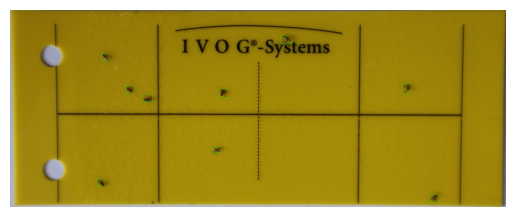

In [12]:
#manual labels on the cropped image
#green boxes for ground truth
label_folder = "/user/christoph.wald/u15287/big-scratch/02_splitted_data/train_labeled/labels_uncropped"
label_file = os.path.splitext(image_file)[0] + ".txt"
label_path = os.path.join(label_folder, label_file)
with open(label_path, "r") as f:
    yolo_labels = f.read().splitlines()
yolo_rectangles = yolo_labels_to_rectangles(yolo_labels, image.shape)
cropped_yolo_rectangles = transform_rectangles_to_cropped(yolo_rectangles, x, y,  w,h)
image_cropped = image[y:y+h, x:x+w]
image_labels = draw_bounding_boxes(image_cropped, cropped_yolo_rectangles, color = (0,255,0))
show(image_labels)

#### Step 5a: Finding the best mask

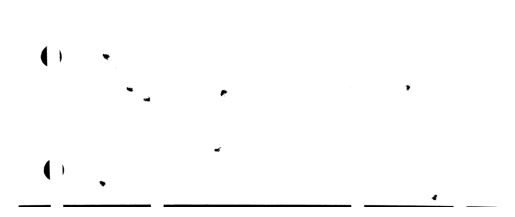

In [13]:
#this is image that is searched for contours
show(create_binary_mask(cropped_image_wo_grid))

8 bounding boxes found.
Green boxes: ground truth, blue boxes: found rectangles


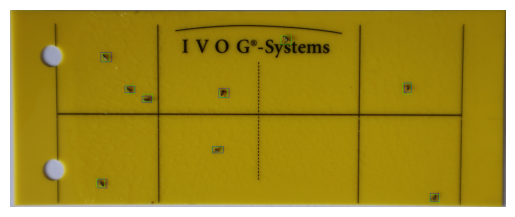

In [14]:
#contours are filtered with this roughly estimated threshold
if "TRIAVA" in image_file: #for whiteflies
    min_area = 100  
    max_area = 1000 
else: #for fungus gnats and leaf miner flies
    min_area = 1000 
    max_area = 10000 

scale = 1.5 #rectangles around the contours are scale, because often the contours do not cover the whole object

max_ratio = 2 #rectangles that have a very long and a very short side (high ratio w/h) are filtered out, because they likely are some other object

rectangles, _ = get_list_of_rectangles(cropped_image_wo_grid, min_area, max_area, scale = 1.5, max_ratio = 2)

image_labels = draw_bounding_boxes(image_labels, rectangles)
print("Green boxes: ground truth, blue boxes: found rectangles")
show(image_labels)

In [15]:
#evalutation by comparing to the manual labels
rectangles = [(x, y, x + w, y + h) for (x, y, w, h) in rectangles]
cropped_yolo_rectangles = [(x, y, x + w, y + h) for (x, y, w, h) in cropped_yolo_rectangles]
metrics, fp_boxes = evaluate_detections(rectangles, cropped_yolo_rectangles)
print(metrics)
print(f"Number of false positives: {len(fp_boxes)}")



{'TP': 8, 'FP': 0, 'FN': 1}
Number of false positives: 0


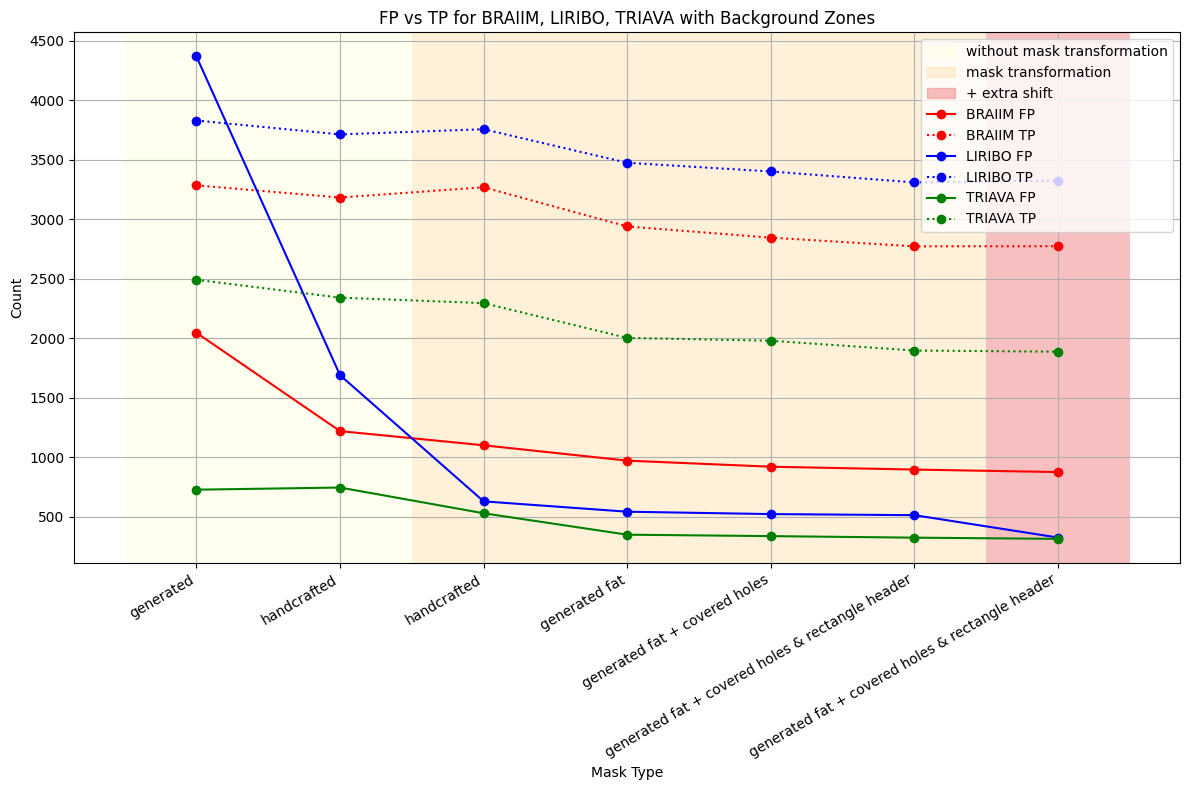

In [16]:
df = pd.read_csv("/user/christoph.wald/u15287/insect_pest_detection/2_4_image_processing/data/mask_testing_collected_results.csv")


# To avoid confusion with repeated mask labels, add index numbers
df["label"] = df.index + 1 # numerical x-axis for plotting
mask_labels = df["mask"] # store mask names separately for tick labels


# Plot all in one graph
plt.figure(figsize=(12, 8))


# Add background colors
plt.axvspan(0.5, 2.5, facecolor='lightyellow', alpha=0.5)
plt.axvspan(2.5, 6.5, facecolor='moccasin', alpha=0.5)
plt.axvspan(6.5, 7.5, facecolor='lightcoral', alpha=0.5)

yellow_patch = mpatches.Patch(color='lightyellow', alpha=0.5, label='without mask transformation')
orange_patch = mpatches.Patch(color='moccasin', alpha=0.5, label='mask transformation')
red_patch = mpatches.Patch(color='lightcoral', alpha=0.5, label='+ extra shift')


# BRAIIM
plt.plot(df["label"], df["FP BRAIIM"], marker="o", linestyle="-", color="red", label="BRAIIM FP")
plt.plot(df["label"], df["TP BRAIIM"], marker="o", linestyle=":", color="red", label="BRAIIM TP")


# LIRIBO
plt.plot(df["label"], df["FP LIRIBO"], marker="o", linestyle="-", color="blue", label="LIRIBO FP")
plt.plot(df["label"], df["TP LIRIBO"], marker="o", linestyle=":", color="blue", label="LIRIBO TP")


# TRIAVA
plt.plot(df["label"], df["FP TRIAVA"], marker="o", linestyle="-", color="green", label="TRIAVA FP")
plt.plot(df["label"], df["TP TRIAVA"], marker="o", linestyle=":", color="green", label="TRIAVA TP")


# Replace x-axis ticks with mask names
plt.xticks(df["label"], mask_labels, rotation=30, ha="right")


plt.xlabel("Mask Type")
plt.ylabel("Count")
plt.grid(visible = True)
plt.title("FP vs TP for BRAIIM, LIRIBO, TRIAVA with Background Zones")
plt.legend()
plt.legend(handles=[
    yellow_patch, orange_patch, red_patch,
    *plt.gca().get_legend_handles_labels()[0]  # keep existing FP/TP lines
], loc='best')
plt.tight_layout()
plt.show()

#### Step 5b: Finding the best thresholds for filtering the rectangles

Box sizes and ratio of sides

rectangles_BRAIIM.txt stats:
95th percentile area, max: 41704, 97980
Square deviation 90th: 0.58


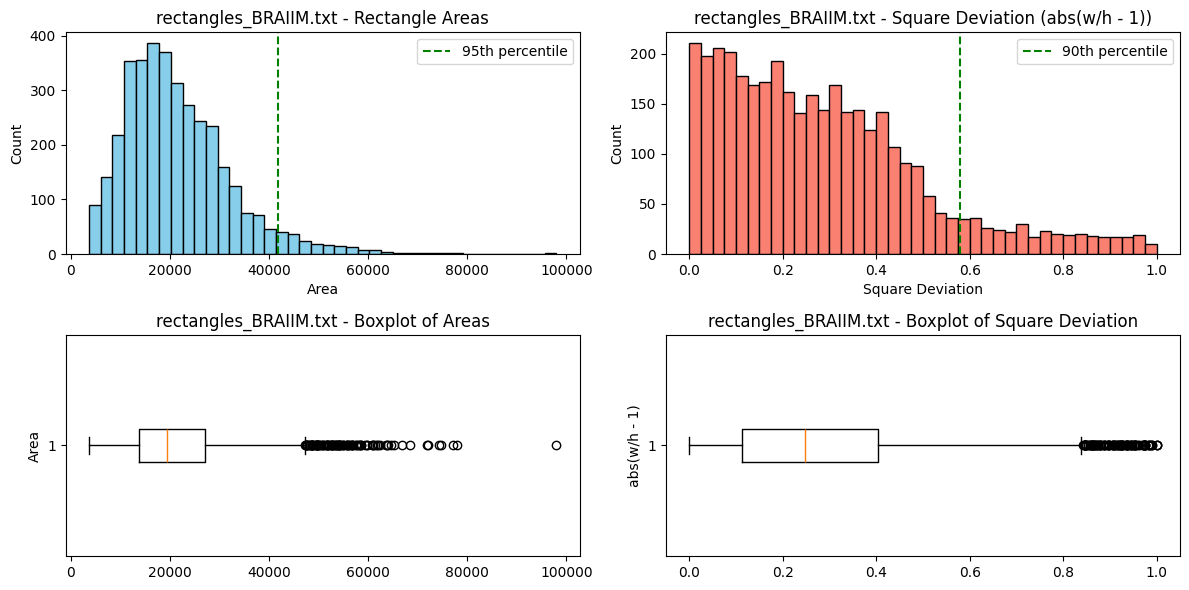

rectangles_LIRIBO.txt stats:
95th percentile area, max: 22340, 28525
Square deviation 90th: 0.63


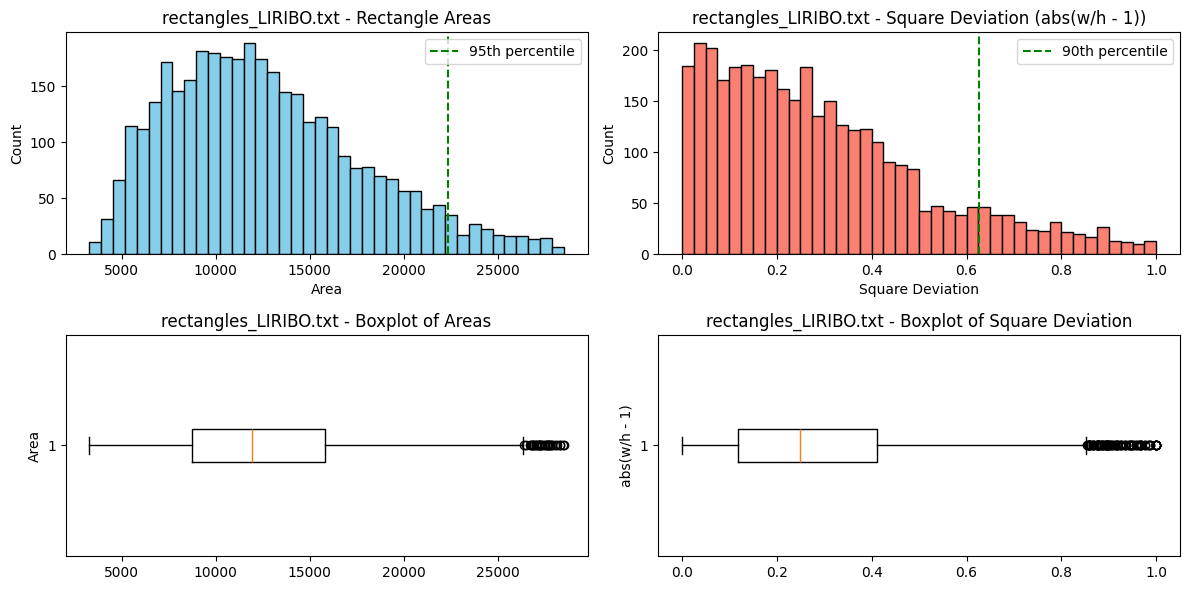

rectangles_TRIAVA.txt stats:
95th percentile area, max: 3168, 7830
Square deviation 90th: 0.73


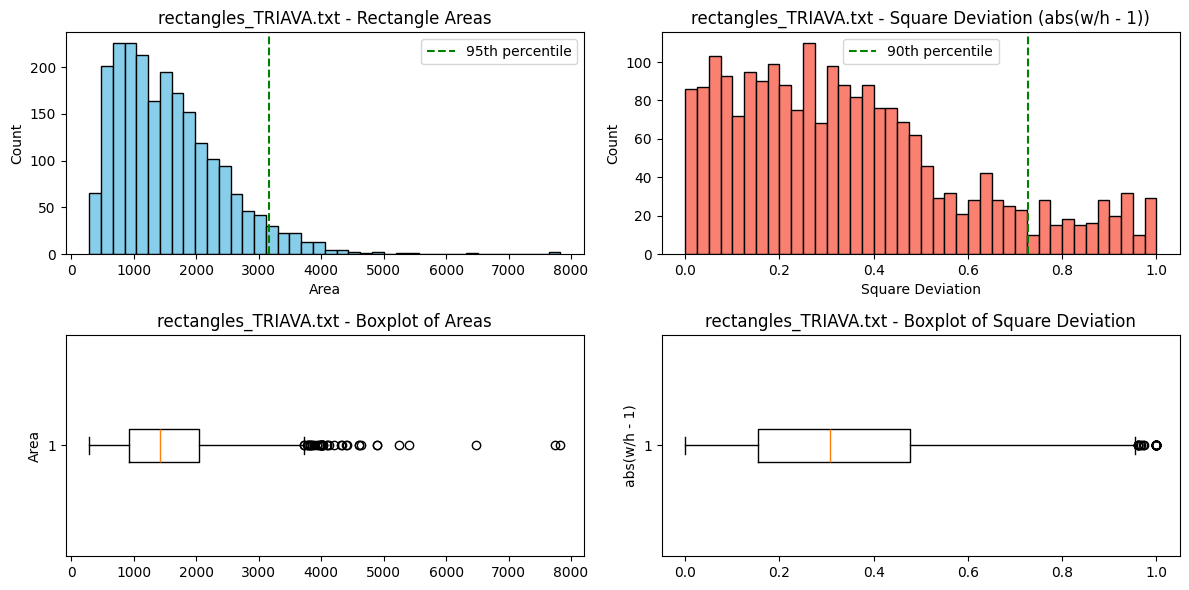

In [17]:
# --- Step 1: Load rectangle files ---
rect_folder = "/user/christoph.wald/u15287/insect_pest_detection/2_4_image_processing/rectangles"
rect_files = sorted([f for f in os.listdir(rect_folder) if f.endswith(".txt")])

for file_name in rect_files:
    areas = []
    square_devs = []

    with open(os.path.join(rect_folder, file_name), "r") as f:
        for line in f:
            line = line.strip()
            if line:  # skip empty lines
                rects = ast.literal_eval(line)
                for x, y, w, h in rects:
                    areas.append(w * h)
                    square_devs.append(abs(w / h - 1))  # deviation from square

    areas = np.array(areas)
    square_devs = np.array(square_devs)

    # --- Step 2: Compute percentiles ---
    print(f"{file_name} stats:")
    print(f"95th percentile area, max: {np.percentile(areas,95):.0f}, {np.max(areas)}")

    print(f"Square deviation 95th: { np.percentile(square_devs, 95):.2f}")

    # --- Step 3: Plot distributions ---
    plt.figure(figsize=(12, 6))
    
    # Histogram for areas
    plt.subplot(2, 2, 1)
    plt.hist(areas, bins=40, color='skyblue', edgecolor='black')
    plt.axvline(np.percentile(areas, 95), color='green', linestyle='--', label='95th percentile')
    plt.title(f"{file_name} - Rectangle Areas")
    plt.xlabel("Area")
    plt.ylabel("Count")
    plt.legend()
    
    # Histogram for square deviation with percentile lines
    plt.subplot(2, 2, 2)
    plt.hist(square_devs, bins=40, color='salmon', edgecolor='black')
    plt.axvline(np.percentile(square_devs, 95), color='green', linestyle='--', label='95th percentile')
    plt.title(f"{file_name} - Square Deviation (abs(w/h - 1))")
    plt.xlabel("Square Deviation")
    plt.ylabel("Count")
    plt.legend()
    
    # Boxplot for areas
    plt.subplot(2, 2, 3)
    plt.boxplot(areas, vert = False)
    plt.title(f"{file_name} - Boxplot of Areas")
    plt.ylabel("Area")
    
    # Boxplot for square deviation
    plt.subplot(2, 2, 4)
    plt.boxplot(square_devs, vert= False)
    plt.title(f"{file_name} - Boxplot of Square Deviation")
    plt.ylabel("abs(w/h - 1)")
    
    plt.tight_layout()
    plt.show()


97.0


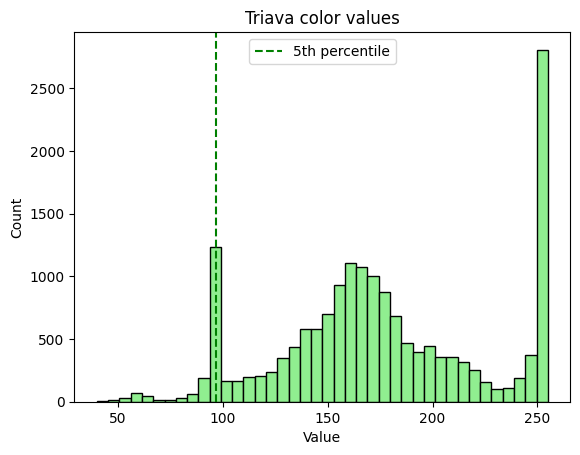

In [32]:
values_file = "/user/christoph.wald/u15287/insect_pest_detection/2_4_image_processing/data/values.txt"

values = []

with open(values_file, "r") as f:
    for line in f:
        line = line.strip()
        if line:  # skip empty lines
            v = ast.literal_eval(line)
            values.extend(v)

print(np.percentile(values, 5))

plt.hist(values, bins=40, color='lightgreen', edgecolor='black')
plt.axvline(np.percentile(values, 5), color='green', linestyle='--', label='5th percentile')
plt.title(f"Triava color values")
plt.xlabel("Value")
plt.ylabel("Count")
plt.legend()
plt.show()

See size comparision below:

green circles: minimum (first cell) and maximum (last cell) of contour area

green rectangles: resulting rectangles of the min/max contour area, scale by 1.5 (a square, because in this example the contour is circle)

blue rectangles: area of the 95th percentile found in box distribution of the respective pest class (depicted as square)

red rectangles: area of the largest rectangle found for the respective pest class (depicted as square)

In [ ]:
#Load 3 images
# Load labels
#Cut out the boxes into an array

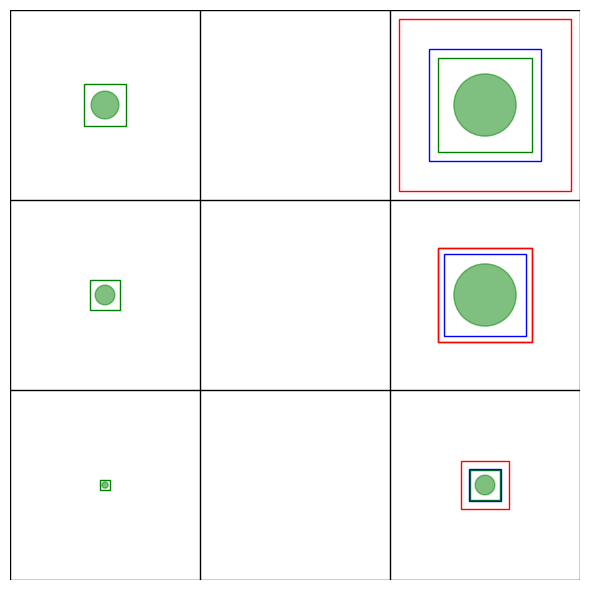

In [19]:
#9x9 grid with examples
areas = [2000, 10000, 1000, 10000, 100, 1000] #contour areas min max
blue = [41704, 22340,3168 ] #95th threshold box size found
red = [97980,28525, 7830] #max box size found


# Compute cell size slightly larger than red[0] side length
cell_size = np.sqrt(red[0]) * 1.1  # 10% larger

fig, ax = plt.subplots(figsize=(6, 6))

# Draw 3x3 grid
for i in range(4):
    ax.axvline(i * cell_size, color='black', linewidth=1)
    ax.axhline(i * cell_size, color='black', linewidth=1)

# Helper to scale rectangle
def scale_rect(x, y, w, h, scale):
    cx = x + w / 2
    cy = y + h / 2
    w_new = w * scale
    h_new = h * scale
    x_new = cx - w_new / 2
    y_new = cy - h_new / 2
    return x_new, y_new, w_new, h_new

# Draw circles and rectangles
for row in range(3):
    # First cell in row
    area_idx = [0, 2, 4][row]
    area = areas[area_idx]
    radius = np.sqrt(area / np.pi)
    center_x = cell_size / 2
    center_y = cell_size / 2 + row * cell_size
    circle = plt.Circle((center_x, center_y), radius, color='green', alpha=0.5)
    ax.add_patch(circle)
    w, h = 2*radius, 2*radius
    x, y, w_s, h_s = scale_rect(center_x - radius, center_y - radius, w, h, 1.5)
    rect = plt.Rectangle((x, y), w_s, h_s, edgecolor='green', facecolor='none', linewidth=1)
    ax.add_patch(rect)

    # Last cell in row
    area_idx = [1, 3, 5][row]
    area = areas[area_idx]
    radius = np.sqrt(area / np.pi)
    center_x = 2.5 * cell_size
    center_y = cell_size / 2 + row * cell_size
    circle = plt.Circle((center_x, center_y), radius, color='green', alpha=0.5)
    ax.add_patch(circle)
    w, h = 2*radius, 2*radius
    x, y, w_s, h_s = scale_rect(center_x - radius, center_y - radius, w, h, 1.5)
    rect = plt.Rectangle((x, y), w_s, h_s, edgecolor='green', facecolor='none', linewidth=1)
    ax.add_patch(rect)

    # Last cell center
    center_x = 2.5 * cell_size
    center_y = cell_size / 2 + row * cell_size

    # Red rectangle
    area = red[row]  # one red per row
    side = np.sqrt(area)
    x = center_x - side / 2
    y = center_y - side / 2
    rect_red = plt.Rectangle((x, y), side, side, edgecolor='red', facecolor='none', linewidth=1)
    ax.add_patch(rect_red)

    # Blue rectangle
    area = blue[row]  # one blue per row
    side = np.sqrt(area)
    x = center_x - side / 2
    y = center_y - side / 2
    rect_blue = plt.Rectangle((x, y), side, side, edgecolor='blue', facecolor='none', linewidth=1)
    ax.add_patch(rect_blue)
# Set equal aspect
ax.set_aspect('equal')
ax.set_xlim(0, 3 * cell_size)
ax.set_ylim(0, 3 * cell_size)
ax.axis('off')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Adapted thresholds are:

increased minimal size of contour: only for fungus gnats

filter out boxes with ratio above the 95th percentile of the distribution: only for fungus gnats and leaf miner flies

filter out everything above 95th percentile of box size: only for fungus gnats and leaf miner flies

filter out all boxes with a value (from the HSV color space) below the 5th percentile of the value distribution: only for whiteflies

In [ ]:
#Better filters
 if "TRIAVA" in image_file:
    min_area_contour = 100  
    max_area_contour = 1000
    scale = 1.5
    max_ratio = 2 
    upper_limit_rectangles = None
    value_threshold =97 # 5th percentile
elif "LIRIBO" in image_file: 
    min_area_contour = 1000 
    max_area_contour = 10000 
    scale = 1.5
    max_ratio = 1.76 #95th percentile
    upper_limit_rectangles = 22340 #95th percentile
    value_threshold = None
elif "BRAIIM" in image_file:
    min_area_contour = 2000 
    max_area_contour = 10000
    scale = 1.5
    max_ratio = 1.75 #95the percentile
    upper_limit_rectangles = 41703 #95th percentil
    value_threshold = None


rectangles, _ = get_list_of_rectangles(cropped_image_wo_grid, min_area_contour, max_area_contour, scale, max_ratio, upper_limit_rectangles, value_threshold)

#for the whiteflies, sometime overlapping rectangles are created, because single instance leads to two contours  
#on of the overlapping boxes is deleted  
if "TRIAVA" in image_file:
    rectangles = remove_smaller_overlaps(rectangles)

Boxes remaining after filtering

7 bounding boxes found.


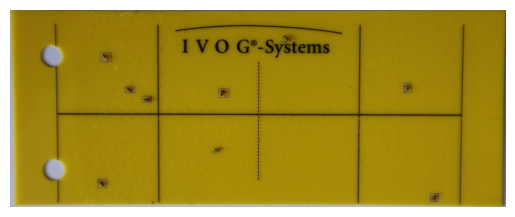

In [24]:
show(draw_bounding_boxes(image_cropped, rectangles))

In [26]:
rectangles = [(x, y, x + w, y + h) for (x, y, w, h) in rectangles]
cropped_yolo_rectangles = [(x, y, x + w, y + h) for (x, y, w, h) in cropped_yolo_rectangles]
metrics, fp_boxes = evaluate_detections(rectangles, cropped_yolo_rectangles)
print(metrics)
print(f"Number of false positives: {len(fp_boxes)}")


{'TP': 7, 'FP': 0, 'FN': 2}
Number of false positives: 0


Boxes that are still false positive (if any)

In [34]:
if fp_boxes:
    show(draw_bounding_boxes(image_cropped, fp_boxes, color = (0,0,255)))

Overview over improvement with adapted thresholds

In [44]:
df = pd.read_csv("/user/christoph.wald/u15287/insect_pest_detection/2_4_image_processing/data/filtering_tests_collected_results.csv")
df

,Unnamed: 0,BRAIIM_p,BRAIIM_FP,LIRIBO_p,LIRIBO_FP,TRIAVA_p,TRIAVA_FP
0,base case,0.760077,875.0,0.910935,325.0,0.857273,314.0
1,min size +1000,0.772532,742.0,NaN,NaN,NaN,NaN
2,Remove >95th percentile box size,0.771651,791.0,0.921632,267.0,0.862201,288.0
3,Remove >95th percentile box ratio,0.762364,788.0,0.909416,304.0,0.858835,286.0
4,remove overlaps,NaN,NaN,NaN,NaN,0.865803,290.0
5,remove <5th percentile value,NaN,NaN,NaN,NaN,0.880897,255.0
6,combined filters,0.787976,596.0,0.919257,252.0,0.889681,232.0


/mnt/lustre-grete/tmp/u15287/ipykernel_3166776/4289503982.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(x, rotation=45, ha='right')


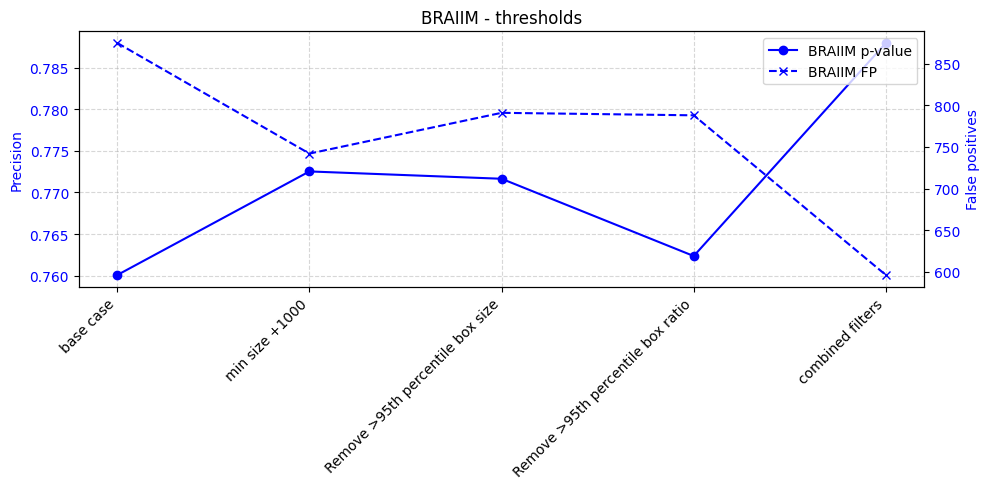

/mnt/lustre-grete/tmp/u15287/ipykernel_3166776/4289503982.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(x, rotation=45, ha='right')


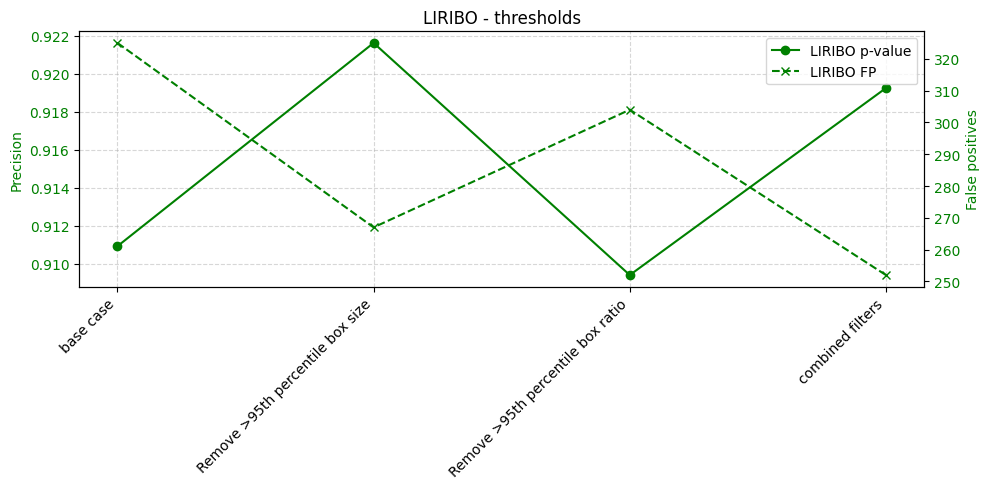

/mnt/lustre-grete/tmp/u15287/ipykernel_3166776/4289503982.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(x, rotation=45, ha='right')


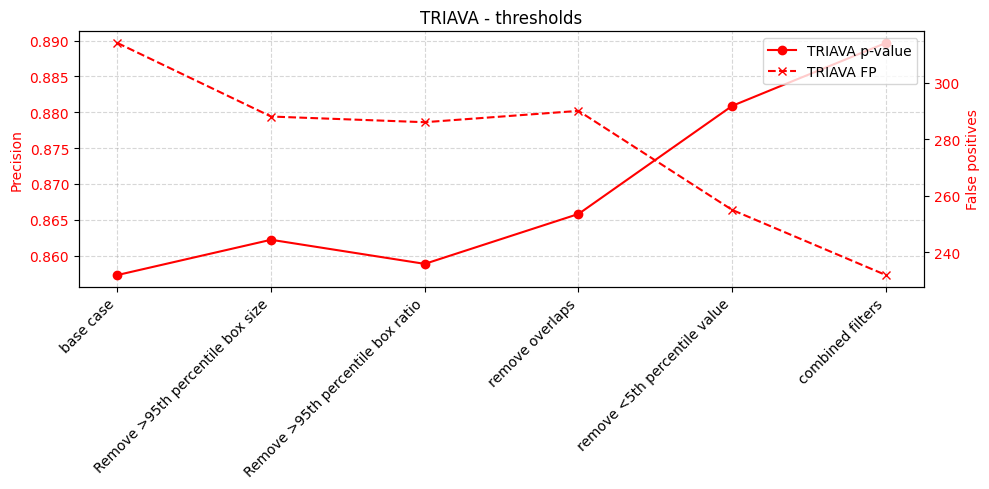

In [45]:
species = ['BRAIIM', 'LIRIBO', 'TRIAVA']
colors = {'BRAIIM': 'blue', 'LIRIBO': 'green', 'TRIAVA': 'red'}

for sp in species:
    # Filter rows where either _p or _FP is not NaN
    mask = df[f'{sp}_p'].notna() | df[f'{sp}_FP'].notna()
    df_filtered = df[mask]
    x = df_filtered['Unnamed: 0']
    
    fig, ax1 = plt.subplots(figsize=(10,5))
    
    # Left y-axis: _p values
    ax1.plot(x, df_filtered[f'{sp}_p'], marker='o', color=colors[sp], label=f'{sp} p-value')
    ax1.set_ylabel('Precision', color=colors[sp])
    ax1.tick_params(axis='y', labelcolor=colors[sp])
    ax1.set_xticklabels(x, rotation=45, ha='right')
    ax1.grid(True, linestyle='--', alpha=0.5)
    
    # Right y-axis: _FP values
    ax2 = ax1.twinx()
    ax2.plot(x, df_filtered[f'{sp}_FP'], marker='x', linestyle='--', color=colors[sp], label=f'{sp} FP')
    ax2.set_ylabel('False positives', color=colors[sp])
    ax2.tick_params(axis='y', labelcolor=colors[sp])
    
    # Combine legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
    
    plt.title(f'{sp} - thresholds')
    plt.tight_layout()
    plt.show()


In [68]:
final_mask_results = pd.read_csv("/user/christoph.wald/u15287/insect_pest_detection/2_4_image_processing/data/metrics_final_mask.csv")
final_test_results = pd.read_csv("/user/christoph.wald/u15287/insect_pest_detection/2_4_image_processing/data/metrics_final_test.csv")
final_mask_results

,prefix,TP,FP,FN,precision,recall
0,BRAIIM,2772,875,1600,0.760077,0.634035
1,LIRIBO,3324,325,1530,0.910935,0.684796
2,TRIAVA,1886,314,5925,0.857273,0.241454


In [69]:
final_test_results

,prefix,TP,FP,FN,precision,recall
0,BRAIIM,2215,596,2157,0.787976,0.506633
1,LIRIBO,2869,252,1985,0.919257,0.591059
2,TRIAVA,1871,232,5940,0.889681,0.239534


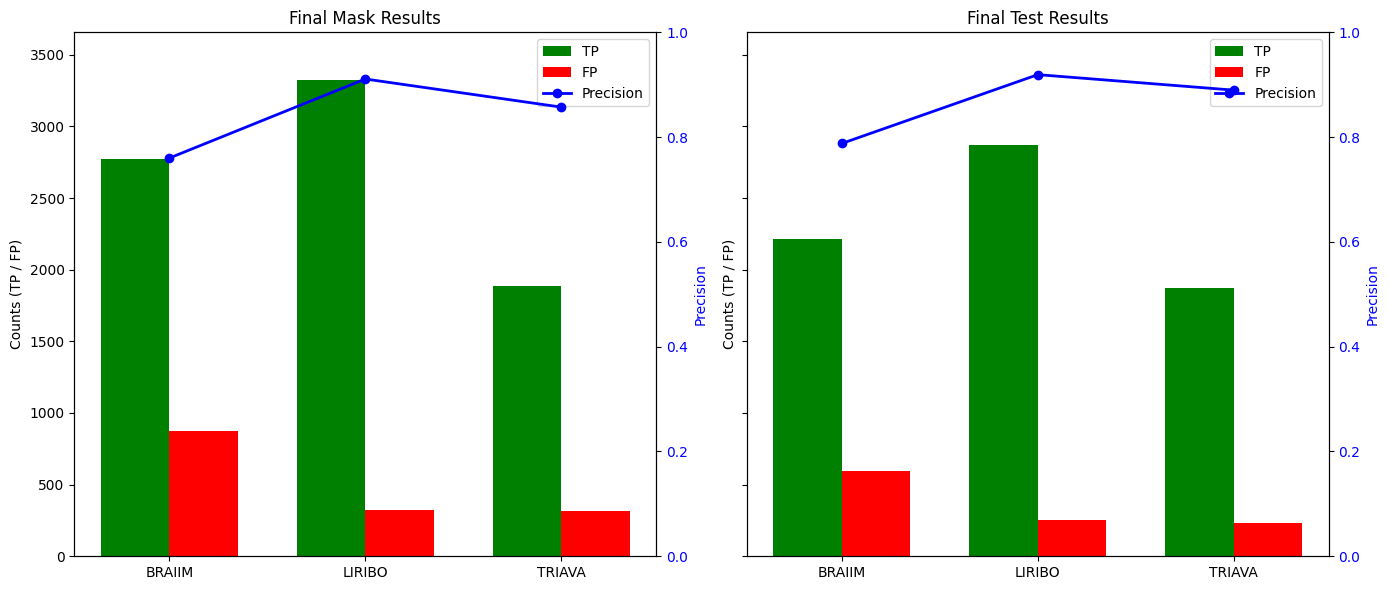

In [70]:
datasets = [final_mask_results, final_test_results]
titles = ['Final Mask Results', 'Final Test Results']

# Bar width and x-axis positions
bar_width = 0.35
prefixes = final_mask_results['prefix']
x = np.arange(len(prefixes))

# Get a common y-axis limit for TP/FP counts
max_count = max([df[['TP','FP']].to_numpy().max() for df in datasets]) * 1.1

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

for i, df in enumerate(datasets):
    ax1 = axes[i]
    
    # Bars for TP and FP
    ax1.bar(x - bar_width/2, df['TP'], width=bar_width, label='TP', color='green')
    ax1.bar(x + bar_width/2, df['FP'], width=bar_width, label='FP', color='red')
    
    # x-axis ticks
    ax1.set_xticks(x)
    ax1.set_xticklabels(prefixes)
    
    # y-axis (counts)
    ax1.set_ylim(0, max_count)
    ax1.set_ylabel('Counts (TP / FP)')
    ax1.set_title(titles[i])
    
    # Dual y-axis for precision
    ax2 = ax1.twinx()
    ax2.plot(x, df['precision'], marker='o', color='blue', label='Precision', linewidth=2)
    ax2.set_ylim(0, 1.0)  # fixed precision scale
    ax2.set_ylabel('Precision', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    
    # Combine legends
    bars_labels = ax1.get_legend_handles_labels()
    line_labels = ax2.get_legend_handles_labels()
    ax1.legend(bars_labels[0] + line_labels[0], bars_labels[1] + line_labels[1], loc='upper right')

plt.tight_layout()
plt.show()

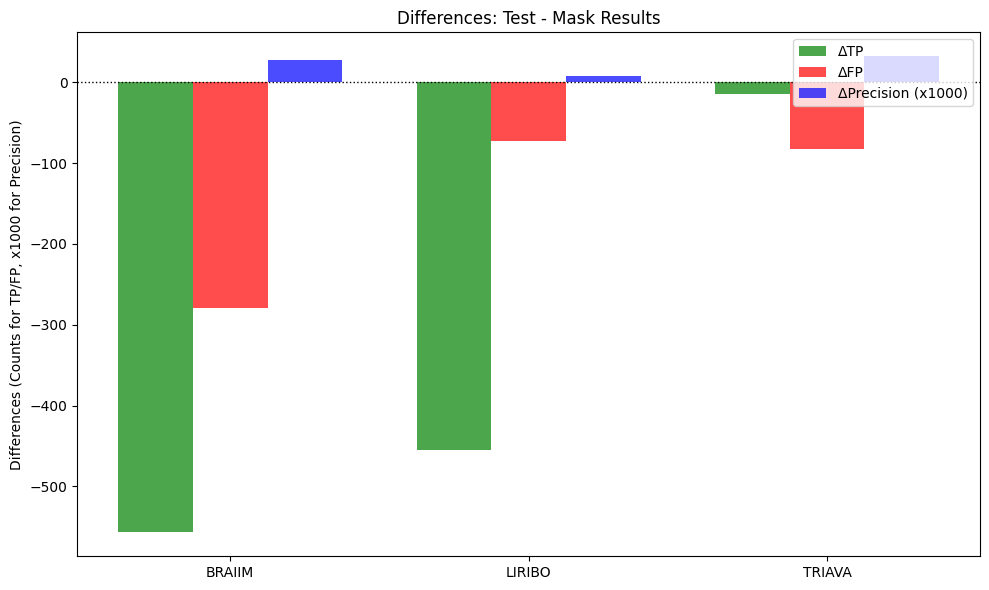

In [73]:
# Compute differences
diff = pd.DataFrame({
    'prefix': final_mask_results['prefix'],
    'TP_diff': final_test_results['TP'] - final_mask_results['TP'],
    'FP_diff': final_test_results['FP'] - final_mask_results['FP'],
    'precision_diff': final_test_results['precision'] - final_mask_results['precision']
})

# X-axis
x = np.arange(len(diff['prefix']))
bar_width = 0.25

fig, ax1 = plt.subplots(figsize=(10,6))

# --- Plot all bars on the same axis so they share zero ---
ax1.bar(x - bar_width, diff['TP_diff'], width=bar_width, color='green', alpha=0.7, label='ΔTP')
ax1.bar(x, diff['FP_diff'], width=bar_width, color='red', alpha=0.7, label='ΔFP')
ax1.bar(x + bar_width, diff['precision_diff']*1000, width=bar_width, color='blue', alpha=0.7, label='ΔPrecision (x1000)')

# Scale note: precision multiplied for visibility
ax1.set_xticks(x)
ax1.set_xticklabels(diff['prefix'])
ax1.set_ylabel('Differences (Counts for TP/FP, x1000 for Precision)')
ax1.set_title('Differences: Test - Mask Results')

# --- Single zero line ---
ax1.axhline(0, color='black', linestyle=':', linewidth=1)

# --- Legends ---
ax1.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [74]:
diff

,prefix,TP_diff,FP_diff,precision_diff
0,BRAIIM,-557,-279,0.027899
1,LIRIBO,-455,-73,0.008322
2,TRIAVA,-15,-82,0.032409


#### Step 6: Preparing the tiles

a) do the training/validiation split (as seen in 2.1.3 03_train_val_split.py)

b) do the tiling (as seen in 2.2 02_create_tiles, but with yolo = False, because labels are in absolute (x,y,w,h) form now)